## Strategy recommendation for airbnb host in seattle

#### Introduction

Since it is located in Seattle, famous for being one of the busiest city in USA. Most people coming to Seattle would most like to come here for business trips rather than tourism purposes.
The airbnb data set is a famous open-access dataset that provide information on the host, the booking and review history. There have been many analysis made on different airbnb datasets but one section that haven't been touched upon is reviews, booking method, or even price, is not the same as revenue. Revenue is the most important in this business. The purpose of this notebook is to make analysis on Airbnb data from January 2016 to  January 2017 data and build a model to predict the potential revenue of a new host.

#### The business question

A new host is trying to enter the Airbnb business in Seattle, can you provide him/her with a housing and pricing strategy that can maximize the revenue?

- Maximizing hosts retrun means more commision for Airbnb
- The code might be implemented by Airbnb as a recommendation system that suggest pricing and policy for new comming host
- The analysis can provide Airbnb insight information on the category of host that maximizes revenue to reach out for marketing

#### Solution overview

- Assumptions: this problem assumes a new-coming host, hence we can't take in the fact that some of the historical properties such as host's rating, previous reviews, properties owned, etc. Properties image and description will not be considered either.
- First we retrieve revenue and booking probability of hosts from the calendar file.
- The host properties is categorized into three groups:
    - House properties: number of rooms, bed, type, locations etc.
    - Host policies: number of extra guest allowed, cancellation policy, varification from rental, etc, as well as host self-verification
    - Pricing strategies: price per person, cleaning fee, price surging over the year, etc.
- A light gradient boosting machine is used with 5-fold cross-validation for revenue predictions.

### Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb


In [2]:
# print null data
def print_null(df):
    for col in df:
        if df[col].isnull().any():
            print('%s has %.0f null values: %.3f%%'%(col, df[col].isnull().sum(), df[col].isnull().sum()/df[col].count()*100))
            
            
# Impute null data using random sampling
def impute_na(X_train, df, variable):
    # make temporary copy
    temp = df.copy()
    
    # extract random from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(), random_state=0, replace=True)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(), variable] = random_sample
    return temp[variable]


# Extract money value
def extract_money(text):
    if isinstance(text, str):
        text = text.replace('$','')
        text = text.replace(',','')
        money = float(text.replace('$',''))
    else:
        money = text
    return money


# Clipping outliers
def clipping_outliers(X_train, df, var):
    IQR = X_train[var].quantile(0.75) - X_train[var].quantile(0.25)
    lower_bound = X_train[var].quantile(0.25) - 4*IQR
    upper_bound = X_train[var].quantile(0.75) + 4*IQR
    no_outliers = len(df[df[var]>upper_bound]) + len(df[df[var]<lower_bound])
    print('There are %i outliers in %s: %.3f%%' %(no_outliers, var, no_outliers/len(df)))
    df[var] = df[var].clip(lower_bound, upper_bound)
    return df


# Plot overview
def plot_overview(df, column, top_count=5):
    agg_func = {'id':['count'],
                   'booking_rate(%)':['mean'],
                   'price_per_person':['mean'],
                   'daily_revenue' : ['mean']} #'revenue_per_guest':['mean']
    temp_df = df.groupby(column).agg(agg_func)
    temp_df.columns = ['_'.join(col)for col in temp_df.columns.values]
    temp_df = temp_df.sort_values(by='id_count', ascending=False)
    temp_df.reset_index(inplace=True)
    if len(temp_df)>top_count:
        temp_df = temp_df.loc[:top_count-1,:]
        
    temp_df = temp_df.sort_values(by='daily_revenue_mean', ascending=False)

    # Plot count and price
    fig1 = plt.figure(figsize=(10,6))
    ax1 = fig1.add_subplot(211)
    ax12 = ax1.twinx()
    temp_df.plot(x=column, y='id_count', kind='bar', color='blue', ax=ax1, width=0.4, position=1, legend=False)
    temp_df.plot(x=column, y='price_per_person_mean', kind='bar', color='red',ax=ax12, width=0.4, position=0, legend=False)
    #temp_df['id_count'].plot(kind='bar', color='blue', ax=ax1, width=0.4, position=1)
    #temp_df['price_mean'].plot(kind='bar', color='red',ax=ax12, width=0.4, position=0)
    ax1.set_ylabel('Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelbottom=False)
    ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax12.set_ylabel('Price per person ($)', color='red')
    ax12.tick_params(axis='y', labelcolor='red', labelbottom=False)
    ax12.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax1.set_xlim(left=-.6)

    ax2 = fig1.add_subplot(212)
    ax22 = ax2.twinx()
    temp_df.plot(x=column, y='booking_rate(%)_mean', kind='bar', color='blue', ax=ax2, width=0.4, position=1, legend=False)
    #temp_df.plot(x=column, y='revenue_per_guest_mean', kind='bar', color='red',ax=ax22, width=0.25, position=0)
    temp_df.plot(x=column, y='daily_revenue_mean', kind='bar', color='red',ax=ax22, width=0.4, position=0, legend=False)
    ax2.set_ylabel('Booking rate(%)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue', labelbottom=False)
    ax2.tick_params(axis='x', rotation=30)
    ax22.set_ylabel('Daily revenue ($)', color='red')
    ax22.tick_params(axis='y', labelcolor='red', labelbottom=False)
    #ax22.tick_params(axis='x', rotation=45)
    ax2.set_xlabel(column)
    ax2.set_xlim(left=-.6)
    ax1.set_title('%s statistics' %column)
    plt.tight_layout()

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

#### Calendar data

In [4]:
df_calendar = pd.read_csv('./data/calendar.csv', parse_dates=['date'])
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
# Calendar data
df_calendar['price'] = df_calendar['price'].apply(lambda x: extract_money(x))
df_calendar['available'] = df_calendar['available'].map({'t':1, 'f':0})
df_calendar['revenue'] = df_calendar['price']*df_calendar['available']

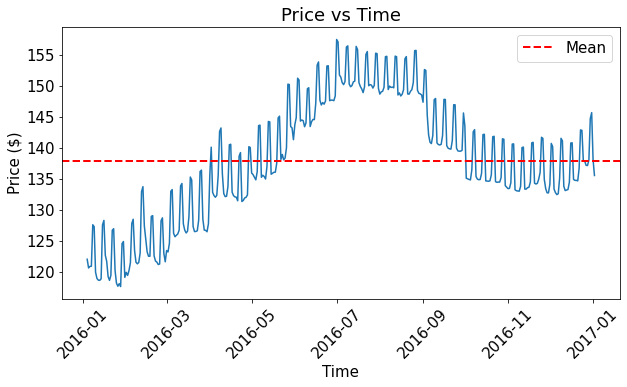

In [6]:
ax = sns.lineplot(x = "date", y = "price",
                 markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation=45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')

###### Observations:
- The graph above presents the existing hosts, they all joined before 2016
- The information about listings are almost one year from January 2016 to January 2017
- The average price is 140 USD. The small peaks are weekends where price and demand both increases.
- The highest price becomes during summer mostly because of holidays.
- The price listed in listing dataframe is just the lowest price, but the prices can be adjusted depending on the host and time

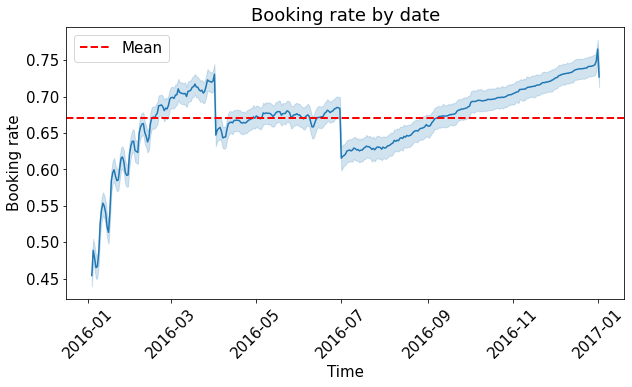

In [7]:
ax = sns.lineplot(x = "date", y = "available",
                 markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation=45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')

##### Observations:
- Booking rate drops during April and July, both holidays month, because people return to their families.
- Booking drops at the beginning and at the end of the year, because of End year holidays

In [8]:
# calculate financial overview of the booking
df_calendar = df_calendar.fillna(0)
overview = df_calendar.groupby('listing_id')['available','price'].mean()
overview.columns = ['booking_rate(%)', 'daily_revenue']
overview['booking_rate(%)'] = overview['booking_rate(%)'] * 100

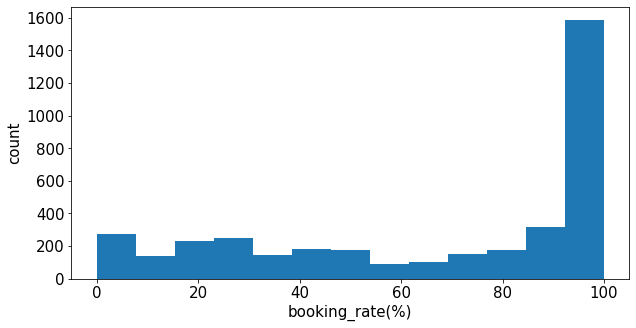

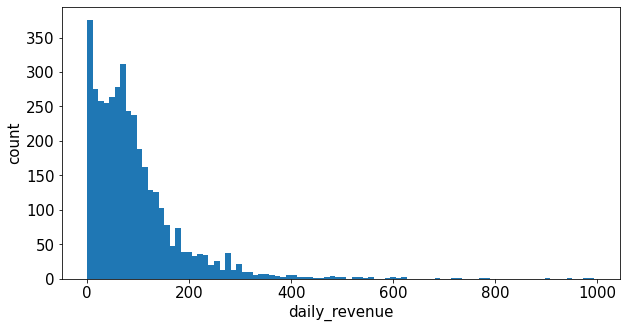

In [9]:
for col in overview.columns:
    plt.figure()
    plt.hist(overview[col], bins='auto')
    plt.xlabel(col)
    plt.ylabel('count')

In [10]:
print('Average daily revenue: %f USD' %np.mean(overview['daily_revenue']))

Average daily revenue: 92.507204 USD


#### Observations:
- Booking rates are usually high, majority of hosts are fully booked throughout the year.
- The daily revenue on average is around 90 USD/day. Some exceptional cases where the host got 1000 USD/day. This can be outliers

In [11]:
overview.head(10)

,booking_rate(%),daily_revenue
listing_id,,
3335,84.657534,101.589041
4291,100.000000,82.000000
5682,84.657534,45.668493
6606,100.000000,92.849315
7369,14.520548,12.342466
9419,100.000000,85.616438
9460,15.616438,17.761644
9531,49.315068,83.589041
9534,71.780822,89.726027


In [12]:
# Actual average price
calendar_booked = df_calendar[df_calendar['price']!=0]
calendar_booked = calendar_booked.groupby('listing_id').agg({'price':['mean','std']}).reset_index()
calendar_booked.columns = ['listing_id','price_avg','price_std']
calendar_booked.head()

,listing_id,price_avg,price_std
0,3335,120.000000,0.000000
1,4291,82.000000,0.000000
2,5682,53.944984,5.025282
3,6606,92.849315,4.520014
4,7369,85.000000,0.000000


#### Listing data

In [13]:
house_properties = ['bathrooms', 'bedrooms', 'beds', 'room_type', 'accommodates', 'bed_type', 'property_type', 'neighbourhood_group_cleansed']
host_policies = ['guests_included', 'minimum_nights', 'maximum_nights', 'cancellation_policy', 'require_guest_phone_verification', 'require_guest_profile_picture', 'host_has_profile_pic', 'host_identity_verified']
pricing_strategies = ['price', 'cleaning_fee', 'extra_people']

In [14]:
# Overview
df_listing = pd.read_csv('./data/listings.csv')
useful_cols = ['id'] + house_properties + host_policies + pricing_strategies
df_listing = df_listing[useful_cols]

In [15]:
# Extract money
for col in pricing_strategies:
    df_listing[col] = df_listing[col].apply(lambda x: extract_money(x))

# Merge with calendar data
df_listing = pd.merge(df_listing, overview, how='left', left_on='id', right_on='listing_id')
df_listing = pd.merge(df_listing, calendar_booked, how='left', left_on='id', right_on='listing_id')
df_listing = df_listing.drop(['listing_id'], axis=1)
df_listing['price_per_person'] = df_listing['price']/df_listing['accommodates']
pricing_strategies = pricing_strategies + ['price_avg','price_std', 'price_per_person']

df_listing.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_group_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person
0,241032,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,2,1,365,moderate,f,f,t,t,85.0,NaN,5.0,94.794521,80.575342,85.000000,0.000000,21.250000
1,953595,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,1,2,90,strict,t,t,t,t,150.0,40.0,0.0,79.726027,136.276712,170.931271,37.225252,37.500000
2,3308979,4.5,5.0,7.0,Entire home/apt,11,Real Bed,House,Queen Anne,10,4,30,strict,f,f,t,t,975.0,300.0,25.0,60.273973,784.657534,1301.818182,356.322687,88.636364
3,7421966,1.0,0.0,2.0,Entire home/apt,3,Real Bed,Apartment,Queen Anne,1,1,1125,flexible,f,f,t,t,100.0,NaN,0.0,39.178082,39.178082,100.000000,0.000000,33.333333
4,278830,2.0,3.0,3.0,Entire home/apt,6,Real Bed,House,Queen Anne,6,1,1125,strict,f,f,t,t,450.0,125.0,15.0,100.000000,462.739726,462.739726,23.703194,75.000000


In [16]:
print_null(df_listing)

bathrooms has 16 null values: 0.421%
bedrooms has 6 null values: 0.157%
beds has 1 null values: 0.026%
property_type has 1 null values: 0.026%
host_has_profile_pic has 2 null values: 0.052%
host_identity_verified has 2 null values: 0.052%
cleaning_fee has 1030 null values: 36.944%
price_avg has 95 null values: 2.552%
price_std has 102 null values: 2.745%


In [17]:
df_listing['revenue_per_guest'] = df_listing['daily_revenue']/df_listing['accommodates']

## Data preprocessing and feature engineering

#### Data to visualize:

- Count: Number of hosts with that property
- Booking rate: The probability of that host being booked
- Price per person: Booking price per accommodate
- Daily revenue: Day-average revenue

### House properties

#### Bathrooms, bedrooms, beds, accommodates

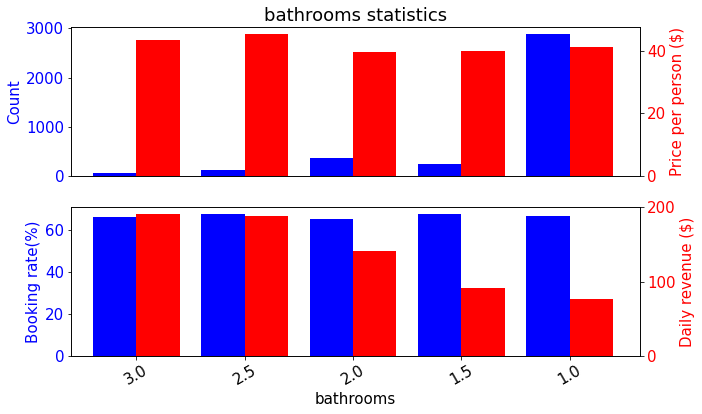

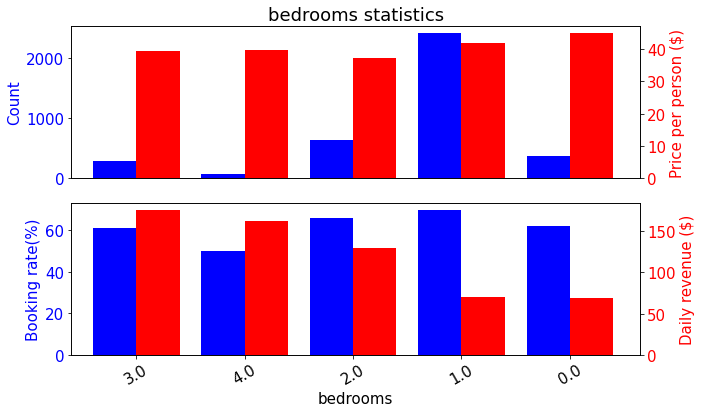

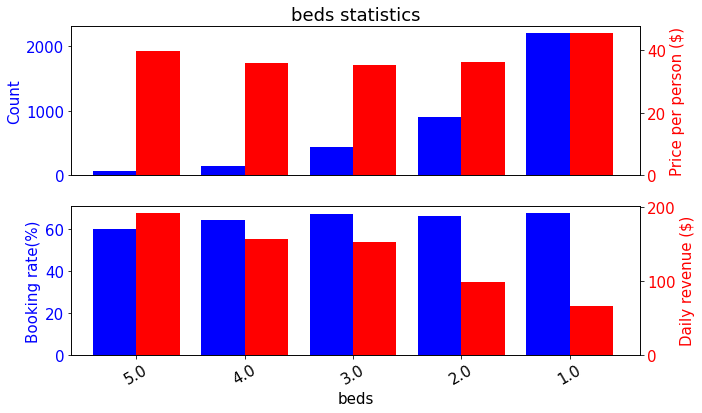

In [18]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    plot_overview(df_listing, col)
    df_listing[col] = impute_na(df_listing, df_listing, col)

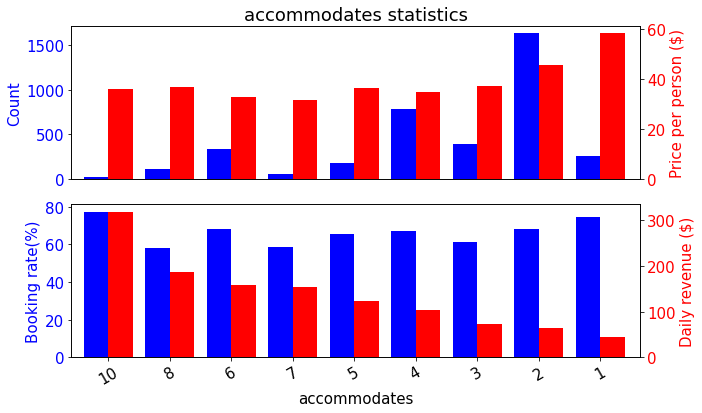

In [19]:
plot_overview(df_listing, 'accommodates', 9)

#### Observations:
- Most of the Airbnb hosts are small with one bedroom and beds, the host most likely targets travellers who are single or coupled.
- But, host can go can also expand or go big. Booking probability does not drop even if you increase in business size. The revenue increases proportinally.

#### Room type and bed type

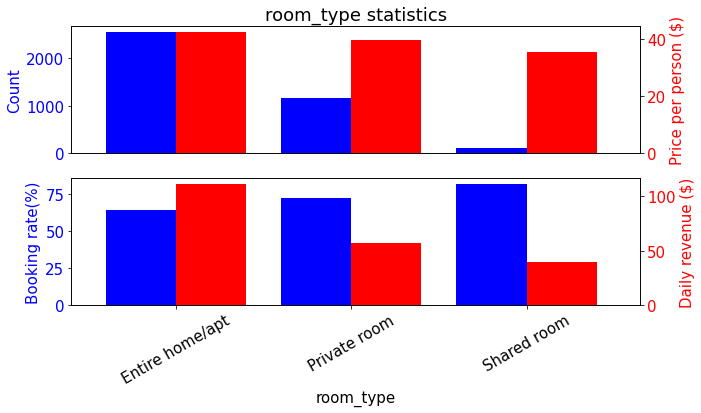

In [20]:
plot_overview(df_listing, 'room_type')
df_listing['room_type'] = df_listing['room_type'].replace({'Shared room': 0, 'Private room':1, 'Entire home/apt':2})

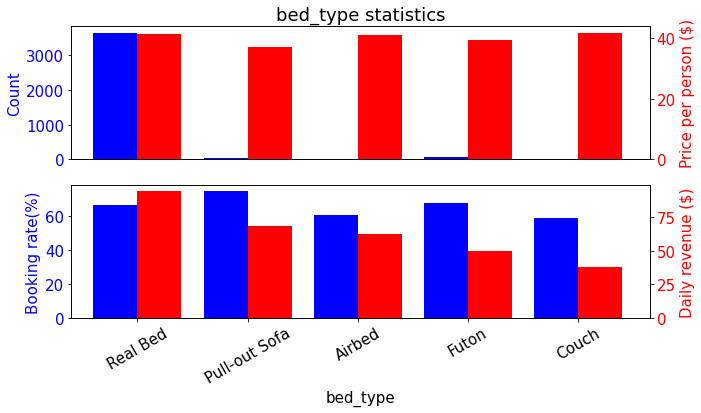

In [21]:
plot_overview(df_listing, 'bed_type')
df_listing['bed_type'] = df_listing['bed_type'].apply(lambda x: 1 if x=='Real Bed' else 0)

#### Observation:
- Most of the host rent out the whole room/apt to one booking. Shared room gets you more booking, but it also get lower revenue
- Real bed get you most revenue and booking rates are also high

#### Properties type and neighborhood

In [22]:
def process_property(x):
    if x in ['House', 'Apartment']:
        return x
    else:
        return 'Other'

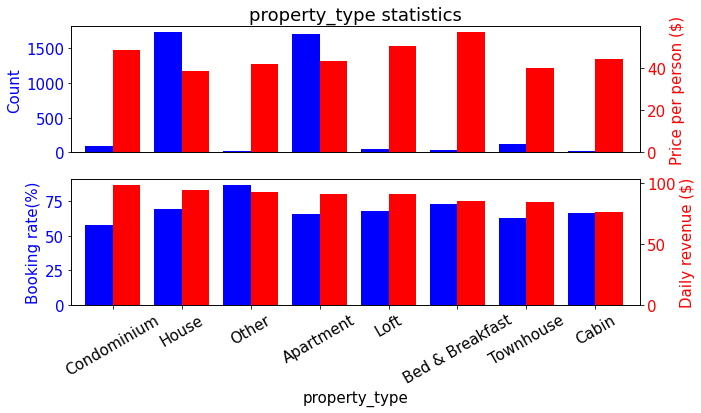

In [23]:
df_listing['property_type'] = impute_na(df_listing, df_listing, 'property_type')
plot_overview(df_listing, 'property_type', 8)
df_listing['property_type'] = df_listing['property_type'].apply(lambda x: process_property(x))

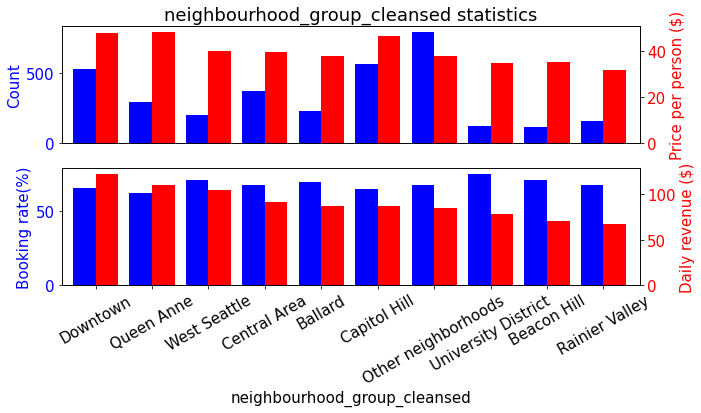

In [24]:
plot_overview(df_listing, 'neighbourhood_group_cleansed', 10)

#### Observations
- The most popular house type that are booked are apartments and houses
- The most booked area are business area such as Downtown or Queen Anne which help earn the most money

In [25]:
top_count_neighborhood = df_listing.groupby('neighbourhood_group_cleansed')['id'].count().sort_values(ascending=False).reset_index()
top_count_neighborhood = top_count_neighborhood.loc[:10, 'neighbourhood_group_cleansed'].tolist()
df_listing['neighbourhood_group_cleansed'] = df_listing['neighbourhood_group_cleansed'].apply(lambda x: x if x in top_count_neighborhood else 'Other neighborhoods')

### Host policy

#### Guest included, minimum nights, maximum nights

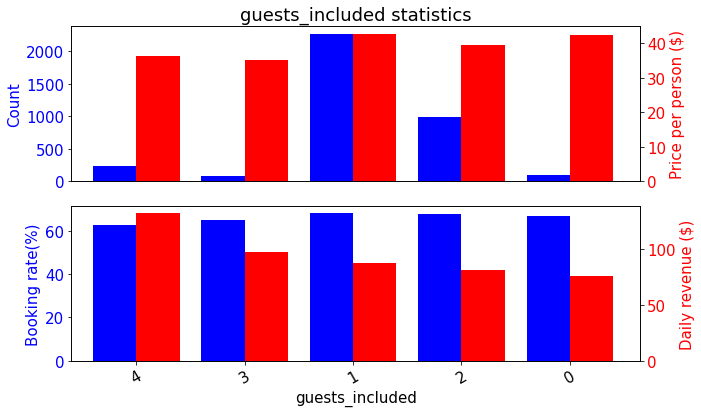

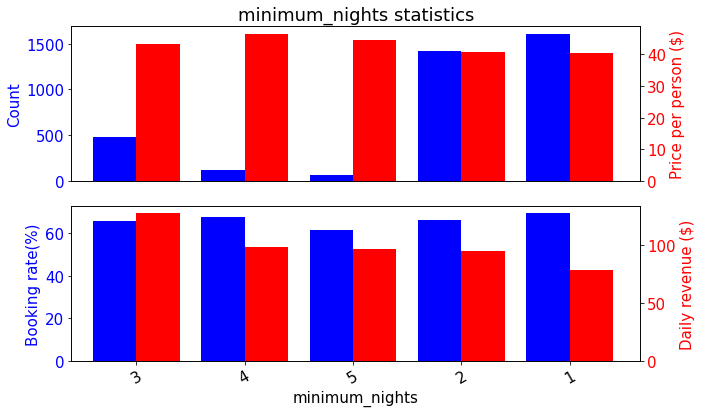

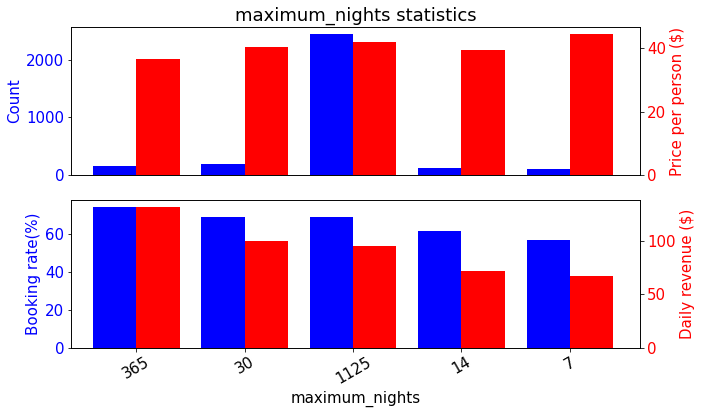

In [26]:
for col in ['guests_included', 'minimum_nights', 'maximum_nights']:
    plot_overview(df_listing, col)

#### Cancelation policy, guest verification requirement

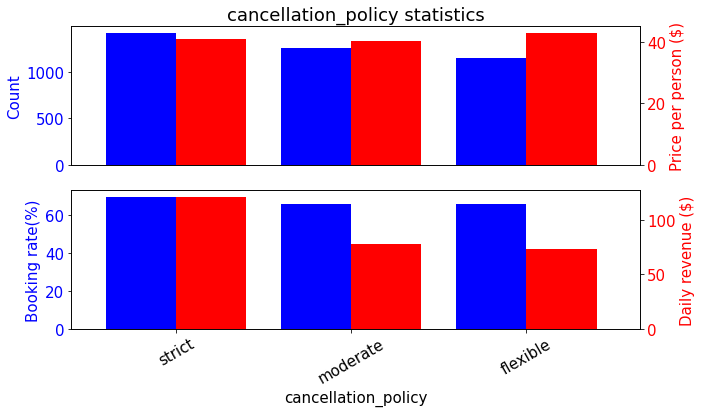

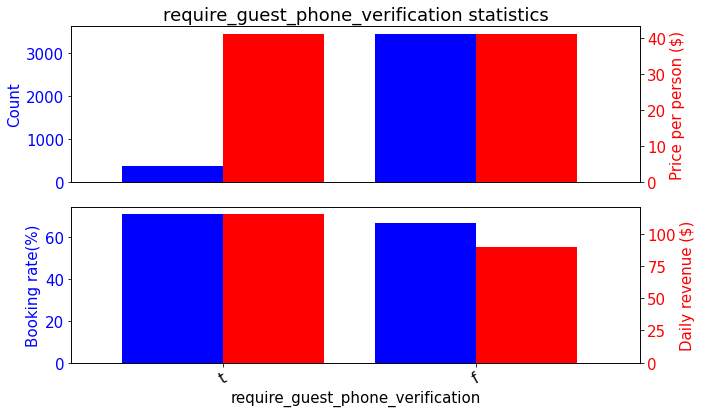

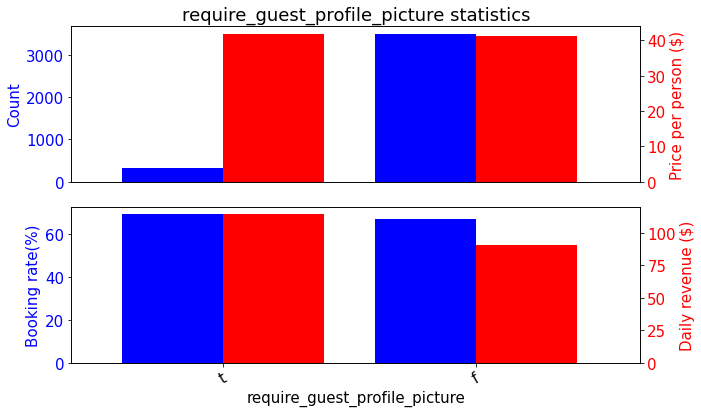

In [27]:
for col in ['cancellation_policy', 'require_guest_phone_verification', 'require_guest_profile_picture']:
    plot_overview(df_listing, col)

#### Observations:
- The more guest that are allowed, increases the revenue more
- Guest staying for short time (1 day) is not good ask them to stay atleast 3 days which will have a increase in revenue
- Being more strict towards the guest allows you get more earning. It will show that you are more serious in the business and you are less likely to be scammed or affected by sudden change of plan by the guests.

In [28]:
df_listing['cancellation_policy'] = df_listing['cancellation_policy'].replace({'strict':2,'moderate':1,'flexible':0})
df_listing['require_guest_phone_verification'] = df_listing['require_guest_phone_verification'].replace({'t':1, 'f':0})

In [29]:
df_listing['require_guest_profile_picture'] = df_listing['require_guest_profile_picture'].replace({'t':1, 'f':0})

#### Host properties

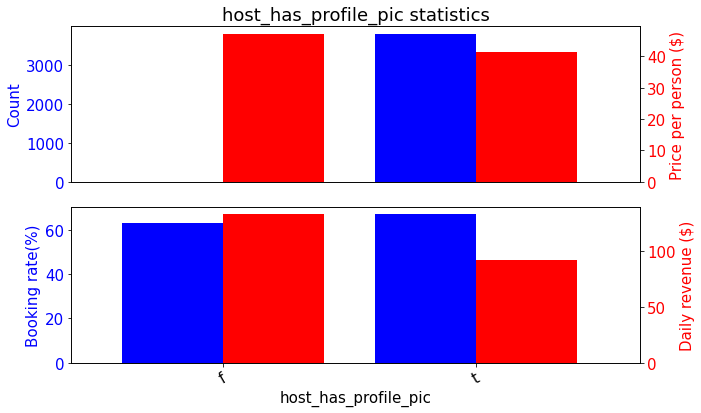

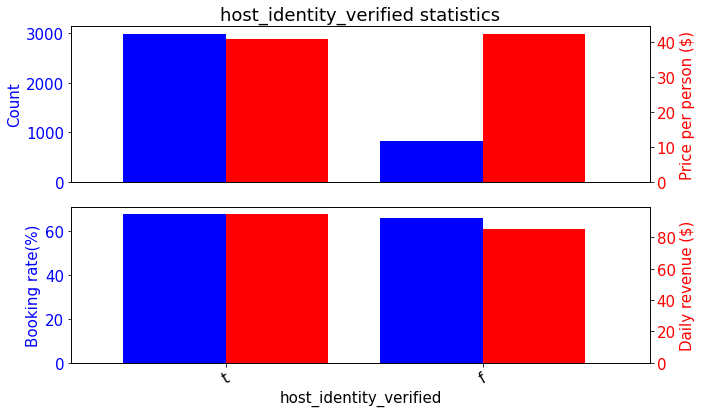

In [30]:
for col in ['host_has_profile_pic', 'host_identity_verified']:
    plot_overview(df_listing, col)
    df_listing[col] = impute_na(df_listing, df_listing, col)
    df_listing[col] = df_listing[col].replace({'t':1, 'f':0})

### Pricing strategies

In [31]:
df_listing['cleaning_fee'] = df_listing['cleaning_fee'].fillna(0)
df_listing['price_avg'] = df_listing['price_avg'].fillna(df_listing['price'])
df_listing['price_std'] = df_listing['price_std'].fillna(0)

Text(0.5, 1.0, 'Pair-wise correlation')

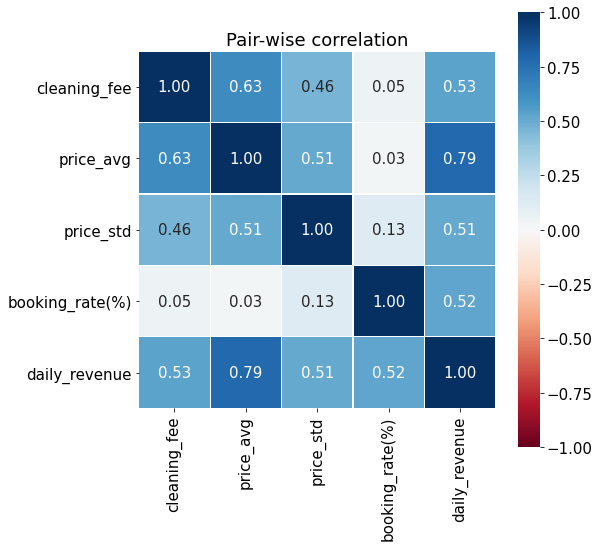

In [32]:
corr_cols = ['cleaning_fee', 'price_avg', 'price_std', 'booking_rate(%)', 'daily_revenue']
colormap = plt.cm.RdBu
plt.figure(figsize=(8,8))
sns.heatmap(df_listing[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True, fmt='.2f')
plt.title('Pair-wise correlation')

#### Observations:
- The more host charges its guest, the more revenue
- The size of host doesn't affect the booking probability

### Knowledge-based features

In [34]:
df_listing['accom_per_bed'] = df_listing['accommodates']/df_listing['beds']
df_listing['baths_per_bed'] = df_listing['bathrooms']/df_listing['beds']
df_listing['extra_guest_ratio'] = df_listing['guests_included']/df_listing['accommodates']
df_listing['price_surge_percent'] = (df_listing['price_avg']/df_listing['price']-1)*100
df_listing['price_std_percent'] = df_listing['price_std']/df_listing['price']*100
df_listing['cleaning_fee_percent'] = df_listing['cleaning_fee']/df_listing['price']*100
df_listing['guest_fee_percent'] = df_listing['extra_people']/df_listing['price']*100

### Overall view

In [36]:
corr_cols = ['beds', 'bathrooms', 'accommodates', 'room_type', 'minimum_nights', 'cancellation_policy', 'require_guest_phone_verification', 'host_has_profile_pic', 'extra_guest_ratio',
           'price_surge_percent', 'price_std_percent','price', 'price_per_person', 'booking_rate(%)', 'daily_revenue','revenue_per_guest']

Text(0.5, 1.0, 'Pair-wise correlation')

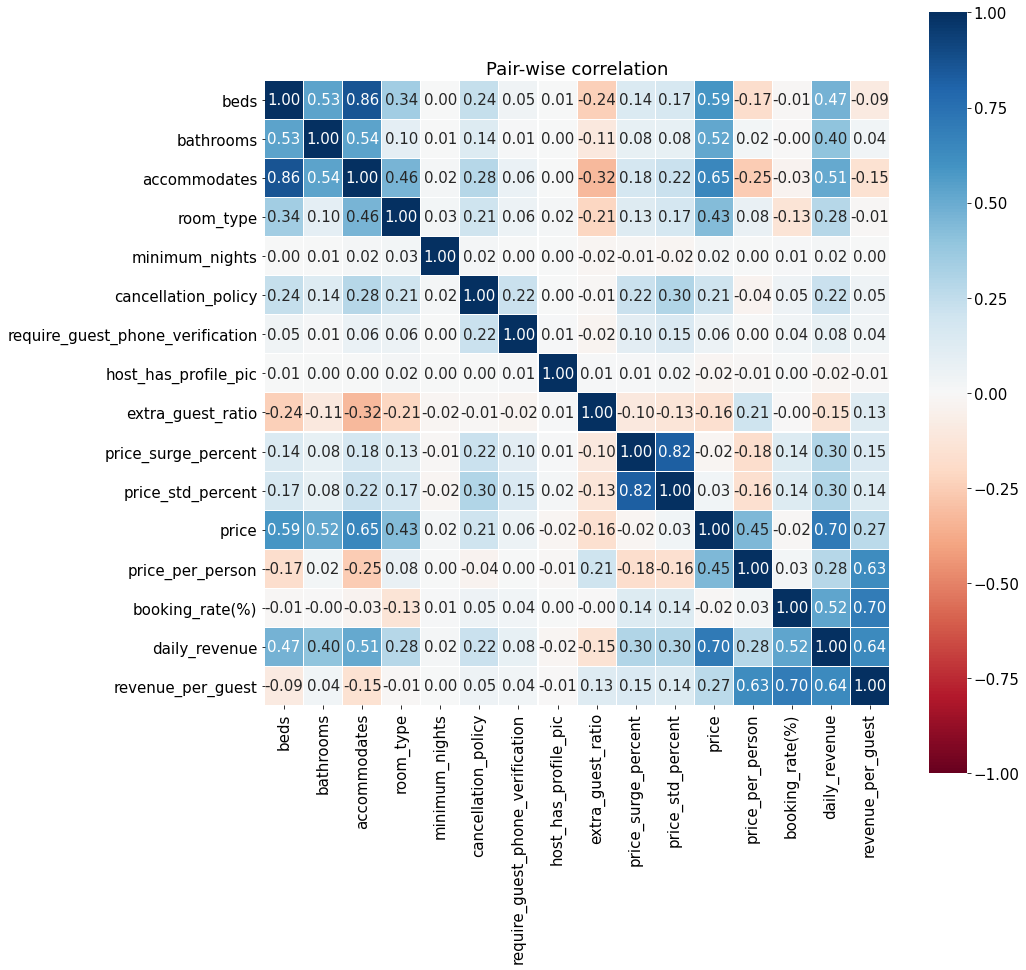

In [38]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
sns.heatmap(df_listing[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

#### Observations:
- The bigger the business size meaning # of rooms, guests etc. the higher daily income will be generated
- Host of any size have similar probablity in getting booked
- To increase the daily revenue, the quality of host business needs to be high as well and fleibilty and strict level doesn't reflect too much on revenue

## Building Model

### Preparing the data

In [39]:
train_data = df_listing.rename(index=str, columns={'neighbourhood_group_cleansed':'neighborhood'})
train_data = pd.get_dummies(train_data, columns=['property_type', 'neighborhood'], prefix=['property_type', 'neighborhood'])

In [40]:
for col in ['price', 'daily_revenue']:
    train_data = clipping_outliers(train_data, train_data, col)

There are 42 outliers in price: 0.011%
There are 37 outliers in daily_revenue: 0.010%


In [41]:
train_data.tail()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person,revenue_per_guest,accom_per_bed,baths_per_bed,extra_guest_ratio,price_surge_percent,price_std_percent,cleaning_fee_percent,guest_fee_percent,property_type_Apartment,property_type_House,property_type_Other,neighborhood_Ballard,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Downtown,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_University District,neighborhood_West Seattle
3813,8101950,2.0,3.0,3.0,2,6,1,1,3,1125,2,0,0,1,1,359.0,230.0,0.0,8.767123,31.473973,359.000000,0.000000,59.833333,5.245662,2.0,0.666667,0.166667,0.000000,0.000000,64.066852,0.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3814,8902327,1.0,1.0,2.0,2,4,1,3,2,29,1,0,0,1,1,79.0,50.0,25.0,74.794521,74.945205,100.201465,24.163043,19.750000,18.736301,2.0,0.500000,0.750000,26.837298,30.586130,63.291139,31.645570,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3815,10267360,1.0,1.0,1.0,2,2,1,2,1,7,1,0,0,1,0,93.0,35.0,20.0,24.109589,21.189041,87.886364,8.164166,46.500000,10.594521,2.0,1.000000,1.000000,-5.498534,8.778673,37.634409,21.505376,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3816,9604740,1.0,0.0,1.0,2,2,1,1,3,1125,1,0,0,1,1,99.0,45.0,0.0,49.041096,48.550685,99.000000,0.000000,49.500000,24.275342,2.0,1.000000,0.500000,0.000000,0.000000,45.454545,0.000000,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3817,10208623,1.5,2.0,1.0,2,3,1,1,1,1125,0,0,0,1,1,87.0,0.0,0.0,1.917808,1.668493,87.000000,0.000000,29.000000,0.556164,3.0,1.500000,0.333333,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [42]:
# Get features and target
unused_cols = ['id', 'booking_rate(%)', 'daily_revenue','price_std', 'revenue_per_guest',
              'price_avg','cleaning_fee', 'extra_people']
features = [col for col in train_data.columns if col not in unused_cols]
train = train_data[features][:-4]
test = train_data[features][-4:]
target_booking = train_data['booking_rate(%)'][:-4]
target_revenue = train_data['daily_revenue'][:-4]
train.to_csv('train.csv')

In [43]:
test.head()

,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,price_per_person,accom_per_bed,baths_per_bed,extra_guest_ratio,price_surge_percent,price_std_percent,cleaning_fee_percent,guest_fee_percent,property_type_Apartment,property_type_House,property_type_Other,neighborhood_Ballard,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Downtown,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_University District,neighborhood_West Seattle
3814,1.0,1.0,2.0,2,4,1,3,2,29,1,0,0,1,1,79.0,19.75,2.0,0.5,0.750000,26.837298,30.586130,63.291139,31.645570,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3815,1.0,1.0,1.0,2,2,1,2,1,7,1,0,0,1,0,93.0,46.50,2.0,1.0,1.000000,-5.498534,8.778673,37.634409,21.505376,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3816,1.0,0.0,1.0,2,2,1,1,3,1125,1,0,0,1,1,99.0,49.50,2.0,1.0,0.500000,0.000000,0.000000,45.454545,0.000000,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3817,1.5,2.0,1.0,2,3,1,1,1,1125,0,0,0,1,1,87.0,29.00,3.0,1.5,0.333333,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0


### Model

In [45]:
"""
parameters = {'num_leaves':np.arange(30,120,1),
             'max_depth':[7,8,9,10],
             'min_child_sample': np.arange(15,80,1),
             'reg_lambda':np.arange(0.1,0.5,0.01)}
fit_params = {'verbose':500}
grid_search = RandomizedSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(train[features], target_revenue, **fit_params)
"""

"\nparameters = {'num_leaves':np.arange(30,120,1),\n             'max_depth':[7,8,9,10],\n             'min_child_sample': np.arange(15,80,1),\n             'reg_lambda':np.arange(0.1,0.5,0.01)}\nfit_params = {'verbose':500}\ngrid_search = RandomizedSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')\ngrid_search.fit(train[features], target_revenue, **fit_params)\n"

### Fitting

In [46]:
# Input parameters
ITERATIONS = 5000
N_FOLDS = 5

In [47]:

model_revenue = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

model_booking = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

In [48]:
oof_train = np.zeros(shape=(len(train)))

### Training

#### Booking probability

In [49]:
# Training for revenue
print('TRAINING FOR REVENUE')
feature_importance_df_booking = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_booking.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_booking.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_booking.iloc[val_idx]
    model_booking.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_booking.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_booking.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_booking = pd.concat([feature_importance_df_booking, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_booking)
print('Training CV score: %.5f' %score)

TRAINING FOR REVENUE
Fold no 1/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 23.9205	valid_1's l1: 28.3892
[1000]	training's l1: 20.7519	valid_1's l1: 27.581
[1500]	training's l1: 18.6265	valid_1's l1: 27.3155
[2000]	training's l1: 16.939	valid_1's l1: 27.213
Early stopping, best iteration is:
[2260]	training's l1: 16.1544	valid_1's l1: 27.1945
Fold no 2/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 24.2075	valid_1's l1: 27.9132
[1000]	training's l1: 21.061	valid_1's l1: 27.1442
[1500]	training's l1: 18.8925	valid_1's l1: 26.8312
[2000]	training's l1: 17.1173	valid_1's l1: 26.7063
[2500]	training's l1: 15.6631	valid_1's l1: 26.6338
Early stopping, best iteration

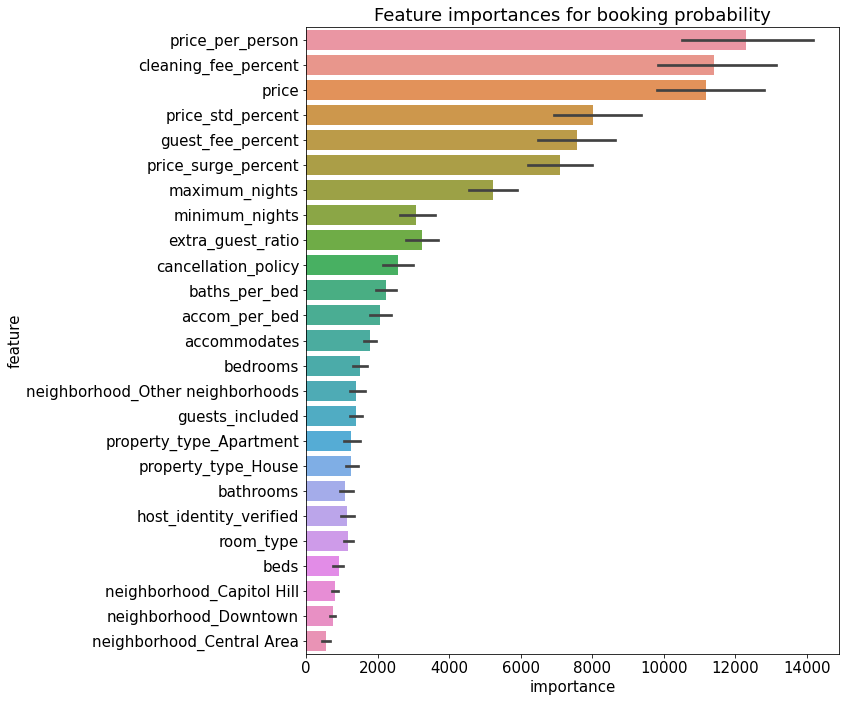

In [50]:
# Visualization
cols = (feature_importance_df_booking[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_booking.loc[feature_importance_df_booking.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for booking probability')
plt.tight_layout()

#### Revenue

In [51]:
# Training for revenue
print('TRAINING FOR BOOKING')
feature_importance_df_revenue = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_revenue.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_revenue.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_revenue.iloc[val_idx]
    model_revenue.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_revenue.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_revenue.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_revenue = pd.concat([feature_importance_df_revenue, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_revenue)
print('Training CV score: %.5f' %score)

TRAINING FOR BOOKING
Fold no 1/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 32.0038	valid_1's l1: 38.0575
[1000]	training's l1: 28.1794	valid_1's l1: 36.8689
[1500]	training's l1: 25.8351	valid_1's l1: 36.5842
Early stopping, best iteration is:
[1512]	training's l1: 25.7866	valid_1's l1: 36.5761
Fold no 2/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 32.6946	valid_1's l1: 36.4756
[1000]	training's l1: 28.7323	valid_1's l1: 35.16
[1500]	training's l1: 26.2398	valid_1's l1: 34.6793
[2000]	training's l1: 24.2856	valid_1's l1: 34.4653
[2500]	training's l1: 22.6848	valid_1's l1: 34.3052
[3000]	training's l1: 21.224	valid_1's l1: 34.1657
Early stopping, best iteratio

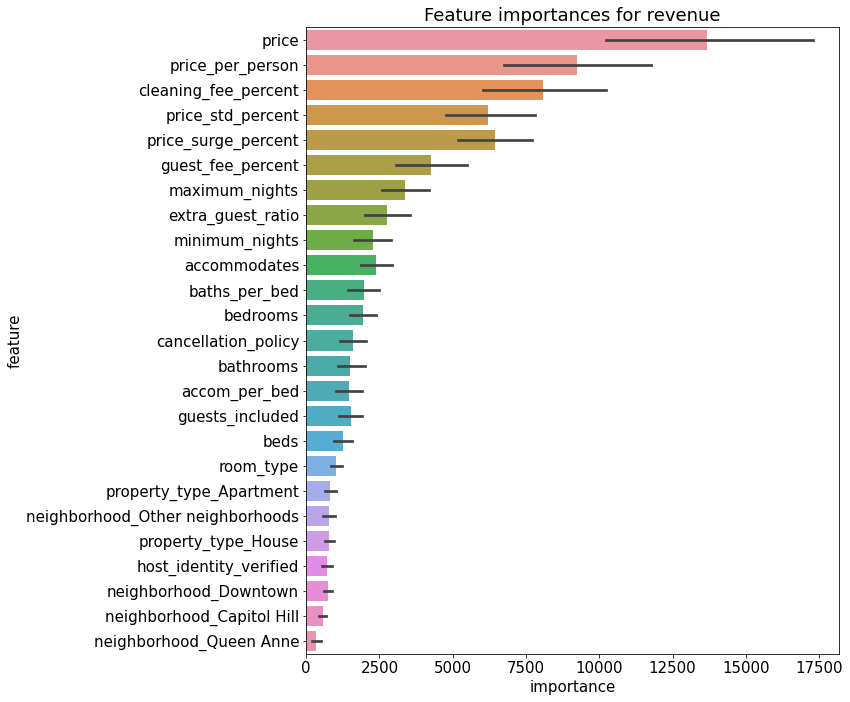

In [52]:
# Visualization
cols = (feature_importance_df_revenue[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_revenue.loc[feature_importance_df_revenue.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for revenue')
plt.tight_layout()

#### Observations:
- The pricing stragtegy for host plays hefty role in daily revenue of the business, The higher the price, cleaning fee or extra charge can help daily revenue
- The bigger the business size also have huge impact on daily income
- Neighborhood and type of house or apartment doesn't have a huge impact in daily revenue growth